In [9]:
# Mount Google Drive (comment out on local)
# Shared folder link (set a shortcut to MyDrive to run): https://drive.google.com/drive/folders/1zwnMrxiQ6o_haHlEzJLAZNv223TxjRcP?usp=sharing
# from google.colab import drive
# drive._mount('/content/drive')

In [10]:
# comment out on local
# !cp '/content/drive/MyDrive/Voynich/corruptions.py' corruptions.py
# !cp '/content/drive/MyDrive/Voynich/uncertainties.py' uncertainties.py
# !cp '/content/drive/MyDrive/Voynich/validation.py' validation.py
# !cp '/content/drive/MyDrive/Voynich/baseline.py' baseline.py

In [11]:
# !pip install numpy==1.19.5
# !pip install scipy==1.7.3
# !pip install nltk==3.6.5
# !pip install gensim==4.1.2
# !pip install smart-open==5.2.1

In [12]:
# Colab
# INFERNO_IT = '/content/drive/MyDrive/Voynich/texts/Inferno_IT.txt'
# ZL = '/content/drive/MyDrive/Voynich/texts/ZL_raw.txt'

# DeepNote
# INFERNO_IT = "ml-project-2-scikit-learn2/texts/Inferno_IT.txt"
# ZL = 'ml-project-2-scikit-learn2/texts/ZL_raw.txt'

# local
INFERNO_IT = 'texts/Inferno_IT.txt'
ZL = 'texts/ZL_raw.txt'

In [13]:
import numpy as np
import numpy.linalg as npl
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import string
import nltk
import gensim
from gensim.models import Word2Vec, FastText
from gensim.corpora.dictionary import Dictionary
nltk.download('punkt')

import corruptions as corr
import uncertainties as unc
import validation as valid
import baseline as base

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liudv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocess text

Firstly, we need to read and clean the input file, removing the index and the chapter numbers, and tokenizing the text.

In [14]:
with open(INFERNO_IT, "r", encoding='utf-8') as doc:
    inferno = doc.read()

In [15]:
# Split text to sentences
inferno = list(map(lambda x: x.strip(), inferno.replace('\n\n\n', '.').replace('\n', ' ').split('.')))
inferno[:50]

['LA DIVINA COMMEDIA  di Dante Alighieri  CANTICA I: INFERNO',
 'Contents   INFERNO  Canto I',
 'Canto II',
 'Canto III',
 'Canto IV',
 'Canto V',
 'Canto VI',
 'Canto VII',
 'Canto VIII',
 'Canto IX',
 'Canto X',
 'Canto XI',
 'Canto XII',
 'Canto XIII',
 'Canto XIV',
 'Canto XV',
 'Canto XVI',
 'Canto XVII',
 'Canto XVIII',
 'Canto XIX',
 'Canto XX',
 'Canto XXI',
 'Canto XXII',
 'Canto XXIII',
 'Canto XXIV',
 'Canto XXV',
 'Canto XXVI',
 'Canto XXVII',
 'Canto XXVIII',
 'Canto XXIX',
 'Canto XXX',
 'Canto XXXI',
 'Canto XXXII',
 'Canto XXXIII',
 'Canto XXXIV',
 '',
 'INFERNO',
 'Inferno Canto I',
 'Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura, ché la diritta via era smarrita',
 'Ahi quanto a dir qual era è cosa dura esta selva selvaggia e aspra e forte che nel pensier rinova la paura!  Tant’ è amara che poco è più morte; ma per trattar del ben ch’i’ vi trovai, dirò de l’altre cose ch’i’ v’ho scorte',
 'Io non so ben ridir com’ i’ v’intrai, tant’ era pien di s

In [16]:
def tokenize_to_words(txt, lang):
    '''
    tokenize text, casefold to lowercase and remove punctuation.
    '''
    tokens = [nltk.tokenize.word_tokenize(sentence, language=lang) for sentence in txt]
    words = [[word.lower() for word in senc if word.isalpha()] for senc in tokens if len(senc) > 0]
    return words

In [17]:
inferno_tokenized = tokenize_to_words(inferno, 'italian')

# Remove index of contents
inferno_tokenized = inferno_tokenized[36:]

# Remove 'Canto' numbering
inferno_tokenized = list(filter(lambda x: x[0] != 'inferno' or x[1] != 'canto' or len(x) != 3, inferno_tokenized))

print(*inferno_tokenized[:10], sep='\n')

['nel', 'mezzo', 'del', 'cammin', 'di', 'nostra', 'vita', 'mi', 'ritrovai', 'per', 'una', 'selva', 'oscura', 'ché', 'la', 'diritta', 'via', 'era', 'smarrita']
['ahi', 'quanto', 'a', 'dir', 'qual', 'era', 'è', 'cosa', 'dura', 'esta', 'selva', 'selvaggia', 'e', 'aspra', 'e', 'forte', 'che', 'nel', 'pensier', 'rinova', 'la', 'paura', 'tant', 'è', 'amara', 'che', 'poco', 'è', 'più', 'morte', 'ma', 'per', 'trattar', 'del', 'ben', 'ch', 'i', 'vi', 'trovai', 'dirò', 'de', 'l', 'altre', 'cose', 'ch', 'i', 'v', 'ho', 'scorte']
['io', 'non', 'so', 'ben', 'ridir', 'com', 'i', 'v', 'intrai', 'tant', 'era', 'pien', 'di', 'sonno', 'a', 'quel', 'punto', 'che', 'la', 'verace', 'via', 'abbandonai']
['ma', 'poi', 'ch', 'i', 'fui', 'al', 'piè', 'd', 'un', 'colle', 'giunto', 'là', 'dove', 'terminava', 'quella', 'valle', 'che', 'm', 'avea', 'di', 'paura', 'il', 'cor', 'compunto', 'guardai', 'in', 'alto', 'e', 'vidi', 'le', 'sue', 'spalle', 'vestite', 'già', 'de', 'raggi', 'del', 'pianeta', 'che', 'mena', '

In [18]:
len([word for sentence in inferno_tokenized for word in sentence])

34124

## Corrupt text

Before proceeding to create the embeddings, we need to modify the original text in order to have the same distribution of uncertainties as in the Voynich manuscript. To do so, we firstly merge toghether the tokenized Inferno to have it as one single clean string, and then we artificially corrupt it using for each type of uncertainty a probability obtained by analyzing the distribution of that uncertainty on the Voynich manuscript.

For Voynich, the **raw** translitterations are scraped with [ivtt](http://www.voynich.nu/extra/sp_transcr.html#ivtt) using the options:
- -c5: Remove hash (#) comment lines, inline comments and page header comments. This also remove text tags.
- -f1 Remove all foliation information. This will also remove spaces before the transliterated text.
- -p2 (**modified**) Remove illustration intrusion codes and replace the paragraph start/end codes by an additional newline.
- -a2 Convert @nnn; codes to a single high ascii byte
- -l1 Remove ligature brackets (but keep text contained between them)
- -s1 Convert certain spaces (those marked with a dot) to blanks

use: ivtt -c5 -f1 -p2 -a2 -l1 -s1 {input file} {output file}

Note that the [original code](http://www.voynich.nu/software/ivtt/ivtt.c) of ivtt by Rene Zandbergen has been sligthly modified to adapt the option -p2 to our needs.

They serve the purpose of analyzing the distribution of ambiguities.
Later, to create embeddings, decisions must be made regarding the options **u** (alternate readings and words with ambiguities), **h** (uncertain spaces), as well as that loci to use (Only P? L, C, R?)

In [19]:
with open(ZL, 'r', encoding='latin-1') as doc:
    voynich = doc.read()

In [20]:
np.unique([*voynich])

array(['\n', ' ', "'", '*', ',', ':', '?', 'I', '[', ']', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '\x82', '\x83',
       '\x84', '\x85', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b',
       '\x8c', '\x91', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97',
       '\x98', '\x99', '\x9a', '\x9b', '\x9c', '\x9f', '¡', '¢', '£', '¤',
       '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²',
       '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿',
       'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Ç', 'È', 'É', 'Ë', 'Ì', 'Î', 'Ï',
       'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', 'Ø', 'ð', 'ñ', 'ò', 'ó', 'ô',
       'õ', 'ö'], dtype='<U1')

In [21]:
voynich_uncertainty_chars = {'ALTERNATE_CHAR': 'ž',
                             'SINGLE_UNCERTAINTY': '?',
                             'DOUBLE_UNCERTAINTY': '??',
                             'UNCERTAIN_SEQUENCE': '???',
                             'UNCERTAIN_SPACE': ','
                            }

In [22]:
voynich_uncertainty_ratios = corr.calculate_uncertainties_statistics(voynich, voynich_uncertainty_chars)

Number of alternate readings: 847, 0.427% of chars
Number of single uncertainty: 237, 0.119% of chars
Number of uncertain sequences: 32, 0.016% of chars
Number of uncertain spaces: 2737, 8.139% of spaces


In [23]:
voynich_uncertainty_ratios

{'ALTERNATE_READINGS_RATIO': 0.004270487753229336,
 'SINGLE_UNCERTAINTY_RATIO': 0.001194929867196402,
 'UNCERTAIN_SEQUENCE_RATIO': 0.0001613407415623834,
 'SPACE_UNCERTAINTY_RATIO': 0.0813880876624342}

For practical purposes, we will ignore in our model uncertain sequences, which occurs only with very low frequency.

In [24]:
voynich_uncertainty_ratios['UNCERTAIN_SEQUENCE_RATIO'] = 0

In [25]:
# Merge back tokenized Inferno as one single string
inferno_clean = list(map(lambda sentence: ' '.join(sentence), inferno_tokenized))
inferno_merged = '\n'.join(inferno_clean)

In [26]:
inferno_merged

'nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura ché la diritta via era smarrita\nahi quanto a dir qual era è cosa dura esta selva selvaggia e aspra e forte che nel pensier rinova la paura tant è amara che poco è più morte ma per trattar del ben ch i vi trovai dirò de l altre cose ch i v ho scorte\nio non so ben ridir com i v intrai tant era pien di sonno a quel punto che la verace via abbandonai\nma poi ch i fui al piè d un colle giunto là dove terminava quella valle che m avea di paura il cor compunto guardai in alto e vidi le sue spalle vestite già de raggi del pianeta che mena dritto altrui per ogne calle\nallor fu la paura un poco queta che nel lago del cor m era durata la notte ch i passai con tanta pieta\ne come quei che con lena affannata uscito fuor del pelago a la riva si volge a l acqua perigliosa e guata così l animo mio ch ancor fuggiva si volse a retro a rimirar lo passo che non lasciò già mai persona viva\npoi ch èi posato un poco il corpo lasso ripr

In [27]:
np.unique([*inferno_merged])

array(['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'z', 'à', 'ä',
       'è', 'é', 'ë', 'ì', 'ï', 'ò', 'ó', 'ö', 'ù', 'ü'], dtype='<U1')

In [28]:
inferno_alphabet = string.ascii_lowercase + ''.join(['à', 'ä', 'è', 'é', 'ë', 'ì',
                                                     'ï', 'ò', 'ó', 'ö', 'ù', 'ü'])
inferno_alphabet

'abcdefghijklmnopqrstuvwxyzàäèéëìïòóöùü'

In [29]:
# Having removed all punctuation, we can still use question marks to indicate
# single, double or uncertain sequences. For uncertain spaces we will however
# use a different character than the comma, which in italian is commonly used as
# a punctuation sign.
inferno_uncertainty_chars = {'ALTERNATE_CHAR': 'ž',
                             'SINGLE_UNCERTAINTY': '?',
                             'DOUBLE_UNCERTAINTY': '??',
                             'UNCERTAIN_SEQUENCE': '???',
                             'UNCERTAIN_SPACE': 'ř'
                            }

# We arbitrarily assume that in the resulting document, 1/2 of the uncertain 
# spaces are actual spaces and the remaining 1/2 are not
actual_space_ratio = 0.5

In [30]:
random.seed(42)
inferno_corrupted = corr.corrupt_text(inferno_merged, voynich_uncertainty_ratios,
                                      inferno_uncertainty_chars, inferno_alphabet,
                                      actual_space_ratio)

Number of alternate readings: 608, 0.446% of chars
Number of single uncertainty: 159, 0.117% of chars
Number of uncertain sequences: 0, 0.000% of chars
Number of uncertain spaces: 2906, 8.447% of spaces


In [31]:
# Split sentences
inferno_corrupted = inferno_corrupted.splitlines()
inferno_corrupted[:10]

['nel mezzořdel cammiřn di nostra vita mi ritrovai per una selva oscura ché la diritta via era smarrita',
 'ahi quanto a dir qual erřa è cosa dura esta selva selvaggia e aspra e forte che nel pensier rinova la paura tant è amara che poco è più morte ma per trattar del ben ch i vi trovai dirò de l ařltre cořse ch i v ho scorte',
 'io non so ben ridir com i v intrai tant era pien di [ó:s]onno a quel punto chře la verace via abbandonai',
 'ma poi ch i fui al piè d un colle giunto là dove terminava quřella valle che m avea di paura il corřcompunto guardai in altoře vidi le sue spalle vestite già de raggi delřpianeta che mena dritto altrui per ogne calle',
 'alřlor fu la paura un poco queta che nel lago del [c:è]or m era durata la notte ch iřpassai con tanta pieta',
 'e come quei che con lena affannata uscito fuor del pelago a la riva si volge ařl acqua perigliosa e guata così lřanimo mio ch ancor fuggiva si volse a retro a rimirar lo passo che non lasciò già mai persona viva',
 'poi chřèi 

## Build vocabulary

To create and evaluate the embeddings on our task of correcting uncertainties given the contexts we will consider different setups, combining two independent decisions.

With respect to the corruptions/uncertainties, we can either:
1. Remove all the words with uncertainties, both for training the embeddings and for extrapolating the contexts.
2. Convert all the uncertainties to a unique single character, keeping then corrupted words in both training and contexts.

With respect to the way embeddings are trained and used, instead, we can:
<ol type="A">
<li>Train the model and for each context predict the word among the options that is maximizing the cosine similarity with the sum of the context vectors.</li>
<li>Add to the model before training a vocabulary with all the possible replacements of uncertain words, forcing the model to learn weights also for those, and for each context predict the words that has the maximum softmax probability, propagating the sum of the context vectors to the output layer using the learned weights.</li>
</ol>

Hence, combining those decisions we will compare 4 resulting models.
Before proceeding, we need to build a list of uncertainties in the corrupted text and a vocabulary of all possible alternatives (used in models of the family B).



In [32]:
# Model 1, removing corrupted words
res_nocorr = [unc.contextualize_sentence(clean_sentence, corr_sentence, 
                                         inferno_uncertainty_chars, inferno_alphabet)
              for clean_sentence, corr_sentence in zip(inferno_clean, inferno_corrupted)]

uncertainty_list_nocorr, inferno_corrupted_nocorr = list(zip(*res_nocorr))

# Merge list of different sentences
uncertainty_list_nocorr = [item for sentence in uncertainty_list_nocorr for item in sentence]

# Split words
inferno_corrupted_nocorr_tokenized = [sentence.split(' ') for sentence in inferno_corrupted_nocorr]

In [33]:
vocab_nocorr = [[word] for uncertainty in uncertainty_list_nocorr for alternative
                in uncertainty.alternatives_list for word in alternative.split(' ')]

In [34]:
len(vocab_nocorr)

18916

In [35]:
# Model 2, replacing corrupted letters
res_repcorr = [unc.contextualize_sentence(clean_sentence, corr_sentence, 
                                          inferno_uncertainty_chars, inferno_alphabet,
                                          convert_uncertainties='£')
               for clean_sentence, corr_sentence in zip(inferno_clean, inferno_corrupted)]

uncertainty_list_repcorr, inferno_corrupted_repcorr = list(zip(*res_repcorr))

# Merge list of different sentences
uncertainty_list_repcorr = [item for sentence in uncertainty_list_repcorr for item in sentence]

# Split words
inferno_corrupted_repcorr_tokenized = [sentence.split(' ') for sentence in inferno_corrupted_repcorr]

In [36]:
vocab_repcorr = [[word] for uncertainty in uncertainty_list_repcorr for alternative
                 in uncertainty.alternatives_list for word in alternative.split(' ')]

## Create embeddings

Firstly, we try embeddings with custom parameters, to have some empiric insight on how they perform. For the moment, we only use the model 1A, eliminating all the words with corruptions and not adding anything to the vocabulary.

In [37]:
print(inferno_corrupted_nocorr_tokenized)

[['nel', 'di', 'nostra', 'vita', 'mi', 'ritrovai', 'per', 'una', 'selva', 'oscura', 'ché', 'la', 'diritta', 'via', 'era', 'smarrita'], ['ahi', 'quanto', 'a', 'dir', 'qual', 'è', 'cosa', 'dura', 'esta', 'selva', 'selvaggia', 'e', 'aspra', 'e', 'forte', 'che', 'nel', 'pensier', 'rinova', 'la', 'paura', 'tant', 'è', 'amara', 'che', 'poco', 'è', 'più', 'morte', 'ma', 'per', 'trattar', 'del', 'ben', 'ch', 'i', 'vi', 'trovai', 'dirò', 'de', 'l', 'ch', 'i', 'v', 'ho', 'scorte'], ['io', 'non', 'so', 'ben', 'ridir', 'com', 'i', 'v', 'intrai', 'tant', 'era', 'pien', 'di', 'a', 'quel', 'punto', 'la', 'verace', 'via', 'abbandonai'], ['ma', 'poi', 'ch', 'i', 'fui', 'al', 'piè', 'd', 'un', 'colle', 'giunto', 'là', 'dove', 'terminava', 'valle', 'che', 'm', 'avea', 'di', 'paura', 'il', 'guardai', 'in', 'vidi', 'le', 'sue', 'spalle', 'vestite', 'già', 'de', 'raggi', 'che', 'mena', 'dritto', 'altrui', 'per', 'ogne', 'calle'], ['fu', 'la', 'paura', 'un', 'poco', 'queta', 'che', 'nel', 'lago', 'del', 'm',

In [38]:
# Word2Vec parameters
min_count = 1                # minimum number of  word occurrencies
vector_size = 100            # embeddings size
window = 5                   # context window size
alpha = 0.5                  # initial learning rate
min_alpha = 0.5              # limit learning rate
epochs = 20                  # epochs number
negative = 20                # number of draws for negative sampling

In [39]:
embeddings_W2V_CBOW = Word2Vec(min_count=min_count, vector_size=vector_size, 
                               window=window, sg=0, negative=negative, alpha=alpha,
                               min_alpha=min_alpha, epochs=epochs, seed=42)
embeddings_W2V_CBOW.build_vocab(inferno_corrupted_nocorr_tokenized)
embeddings_W2V_CBOW.train(inferno_corrupted_nocorr_tokenized, total_examples=embeddings_W2V_CBOW.corpus_count, 
                          epochs=embeddings_W2V_CBOW.epochs)

(439306, 586480)

In [40]:
embeddings_W2V_SkipGram = Word2Vec(min_count=min_count, vector_size=vector_size,
                                   window=window, sg=1, negative=negative, alpha=alpha,
                                   min_alpha=min_alpha, epochs=epochs, seed=42)
embeddings_W2V_SkipGram.build_vocab(inferno_corrupted_nocorr_tokenized)
embeddings_W2V_SkipGram.train(inferno_corrupted_nocorr_tokenized, total_examples=embeddings_W2V_SkipGram.corpus_count, 
                              epochs=embeddings_W2V_SkipGram.epochs)

(439673, 586480)

In [41]:
# FastText parameters
min_count = 1                # minimum number of  word occurrencies
vector_size = 100            # embeddings size
window = 5                   # context window size
alpha = 0.05                 # initial learning rate
min_alpha = 0.0001           # limit learning rate
epochs = 20                  # epochs number
negative = 20                # number of draws for negative sampling
min_n = 3                    # min length of char ngram
max_n = 6                    # max length of char ngram

In [42]:
embeddings_FT_CBOW = FastText(min_count=min_count, vector_size=vector_size,
                              window=window, sg=0, negative=negative, alpha=alpha,
                              min_alpha=min_alpha, epochs=epochs,
                              min_n=min_n, max_n=max_n, seed=42)
embeddings_FT_CBOW.build_vocab(inferno_corrupted_nocorr_tokenized)
embeddings_FT_CBOW.train(inferno_corrupted_nocorr_tokenized, total_examples=embeddings_FT_CBOW.corpus_count, 
                         epochs=embeddings_FT_CBOW.epochs)

(439714, 586480)

In [43]:
embeddings_FT_SkipGram = FastText(min_count=min_count, vector_size=vector_size,
                                  window=window, sg=1, negative=negative, alpha=alpha,
                                  min_alpha=min_alpha, epochs=epochs,
                                  min_n=min_n, max_n=max_n, seed=42)
embeddings_FT_SkipGram.build_vocab(inferno_corrupted_nocorr_tokenized)
embeddings_FT_SkipGram.train(inferno_corrupted_nocorr_tokenized, total_examples=embeddings_FT_SkipGram.corpus_count, 
                             epochs=embeddings_FT_SkipGram.epochs)

(439741, 586480)

## Nearest neighbors

For a first intuitive evaluation of embeddings, we will compare how they perform when asking for the nearest neighbors of 10 words with middle frequency, randomly selected.

In [44]:
words_flatten = [word for sentence in inferno_corrupted_nocorr_tokenized for word in sentence]

In [45]:
# Create Bag of Words
dic = Dictionary([words_flatten])
bow = dic.doc2bow(words_flatten)

# Map word id to word
bow = list(map(lambda x: (dic[x[0]], x[1]), bow))

# Sort bow
bow = sorted(bow, key=lambda x: x[1])

bow[:10]

[('abbaglia', 1),
 ('abbagliato', 1),
 ('abbaia', 1),
 ('abbandonai', 1),
 ('abbandono', 1),
 ('abbandonò', 1),
 ('abbarbicata', 1),
 ('abbatte', 1),
 ('abbi', 1),
 ('abbica', 1)]

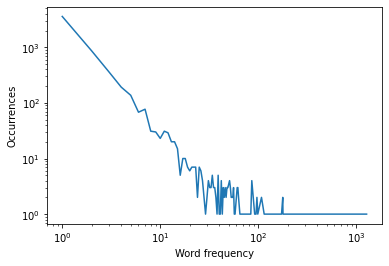

In [46]:
# Extract word frequencies and plot distribution
word_frequency = np.array(list(zip(*bow))[1])
x, y = np.unique(word_frequency, return_counts=True)
plt.loglog(x, y)
plt.xlabel('Word frequency')
plt.ylabel('Occurrences');

As the plot shows, the word frequency distribution follows a power law, with the great majority of words that have very low frequencies, less than 5. This trend is a very common pattern in linguistic analysis and is a property of every language, Voynich included.

We will thus randomly sample 10 words with frequency between 5 and 8. Note that this, despite not having chosen a high frequency, corresponds already to sampling between the roughtly the 88th and the 93rd percentile of the sorted bow matrix.

In [47]:
words_list = list(filter(lambda x: 5 <= x[1] <= 8, bow))
words_list = np.array(list(map(lambda x: x[0], words_list)))

np.random.seed(30)
words_sample = np.random.choice(words_list, 10, replace=False)
words_sample

array(['odo', 'aver', 'pensa', 'sul', 'sùbito', 'dolenti', 'vedere',
       'ebbi', 'piano', 'ten'], dtype='<U10')

Also, we will add to this list three iconic words in the Inferno: *amor* (love), *selva* (forest), *stelle* (stars), aswell as two random words with frequency 1: *ciocca* (strand) and *battesmo* (baptism).

In [48]:
words_sample = np.concatenate((words_sample, np.array(['amor', 'selva', 'stelle', 'occhi', 'cielo'])))
words_sample

array(['odo', 'aver', 'pensa', 'sul', 'sùbito', 'dolenti', 'vedere',
       'ebbi', 'piano', 'ten', 'amor', 'selva', 'stelle', 'occhi',
       'cielo'], dtype='<U10')

In [49]:
# Check the frequency of the mentioned words
dic_words = {x[0]: x[1] for x in bow}
print('Amor: {}'.format(dic_words['amor']),
      'Selva: {}'.format(dic_words['selva']),
      'Stelle: {}'.format(dic_words['stelle']),
      'Occhi: {}'.format(dic_words['occhi']),
      'Cielo: {}'.format(dic_words['cielo']), sep='\n')

Amor: 10
Selva: 11
Stelle: 5
Occhi: 37
Cielo: 10


In [50]:
[{word: embeddings_W2V_CBOW.wv.most_similar(word)} for word in words_sample]

[{'odo': [('infamia', 0.8397964835166931),
   ('contastare', 0.8273570537567139),
   ('pienamente', 0.8261738419532776),
   ('suco', 0.8259614109992981),
   ('iborni', 0.8256613612174988),
   ('ridoglio', 0.8241922855377197),
   ('simil', 0.8194367289543152),
   ('cangia', 0.8192595839500427),
   ('orizzonta', 0.8191149234771729),
   ('discendiam', 0.8174539804458618)]},
 {'aver': [('flegïàs', 0.8433818817138672),
   ('dispietati', 0.8365761637687683),
   ('volesse', 0.8300299048423767),
   ('alessandro', 0.8299257159233093),
   ('destro', 0.8237832188606262),
   ('cicilia', 0.8216171264648438),
   ('rezzo', 0.8180660009384155),
   ('spietati', 0.8149651288986206),
   ('aggiugne', 0.8133135437965393),
   ('piante', 0.8118089437484741)]},
 {'pensa': [('parlasia', 0.9423741102218628),
   ('sospinse', 0.9309630393981934),
   ('fonde', 0.9274328351020813),
   ('focara', 0.9242076873779297),
   ('pulci', 0.9229783415794373),
   ('lusingar', 0.9222831726074219),
   ('montare', 0.922000348567

In [51]:
[{word: embeddings_W2V_SkipGram.wv.most_similar(word)} for word in words_sample]

[{'odo': [('fuoro', 0.9842718839645386),
   ('è', 0.9797706007957458),
   ('eteòcle', 0.9797658324241638),
   ('fatte', 0.9795335531234741),
   ('niego', 0.9783422946929932),
   ('lieto', 0.9772276282310486),
   ('cerchiato', 0.9766700267791748),
   ('appar', 0.9753099679946899),
   ('vecchio', 0.9751527309417725),
   ('spirti', 0.9750978350639343)]},
 {'aver': [('sterpi', 0.9997766017913818),
   ('sofferta', 0.9997408986091614),
   ('italia', 0.9997218251228333),
   ('rotture', 0.9997185468673706),
   ('attese', 0.9997132420539856),
   ('famoso', 0.9997126460075378),
   ('germoglia', 0.9997106194496155),
   ('miserere', 0.9997076988220215),
   ('bui', 0.9997053742408752),
   ('uomo', 0.9997023940086365)]},
 {'pensa': [('stanno', 0.9965602159500122),
   ('fiammella', 0.9965111017227173),
   ('accorsi', 0.9964174628257751),
   ('ghisolabella', 0.9963535666465759),
   ('biasmo', 0.9961010217666626),
   ('aggrappa', 0.9960902333259583),
   ('smozzicate', 0.9960758686065674),
   ('natiche'

In [52]:
[{word: embeddings_FT_CBOW.wv.most_similar(word)} for word in words_sample]

[{'odo': [('sappiendo', 0.9872816205024719),
   ('nodo', 0.9869675636291504),
   ('timido', 0.985020637512207),
   ('ludo', 0.9824327826499939),
   ('chiamando', 0.980663001537323),
   ('deggio', 0.9805757403373718),
   ('escotendo', 0.9801772236824036),
   ('affermando', 0.980002224445343),
   ('seguitando', 0.9796355962753296),
   ('dolce', 0.9796009063720703)]},
 {'aver': [('aveva', 0.9882729053497314),
   ('avere', 0.9859660863876343),
   ('avem', 0.9844799041748047),
   ('er', 0.9822856783866882),
   ('averebbe', 0.9796825647354126),
   ('avrà', 0.9791682362556458),
   ('averei', 0.9767240285873413),
   ('avevan', 0.9726406931877136),
   ('avete', 0.9680737853050232),
   ('trarrei', 0.9678024649620056)]},
 {'pensa': [('pensavi', 0.9899008870124817),
   ('perciò', 0.9868162870407104),
   ('vincerò', 0.9856489896774292),
   ('pensai', 0.9835110306739807),
   ('vivo', 0.9796106219291687),
   ('vincer', 0.979404866695404),
   ('viv', 0.9786506295204163),
   ('pensata', 0.9776929020881

In [53]:
[{word: embeddings_FT_SkipGram.wv.most_similar(word)} for word in words_sample]

[{'odo': [('nodo', 0.8466202616691589),
   ('lodo', 0.8347836136817932),
   ('sodo', 0.833865225315094),
   ('rodo', 0.8071862459182739),
   ('rispondo', 0.8022314310073853),
   ('secondo', 0.7911775708198547),
   ('vado', 0.7873966693878174),
   ('giocondo', 0.7868850827217102),
   ('negar', 0.7655240297317505),
   ('riguardando', 0.7563911080360413)]},
 {'aver': [('saver', 0.8614267110824585),
   ('aveva', 0.8501336574554443),
   ('averei', 0.7998648881912231),
   ('averien', 0.7970209121704102),
   ('avevan', 0.7916484475135803),
   ('avere', 0.7814022302627563),
   ('avem', 0.7537034153938293),
   ('avei', 0.7388995289802551),
   ('graverà', 0.7369255423545837),
   ('averebbe', 0.7232455015182495)]},
 {'pensa': [('pensai', 0.924590528011322),
   ('pensata', 0.9062861204147339),
   ('pensavi', 0.9027813076972961),
   ('penso', 0.8537748456001282),
   ('pensava', 0.8305099606513977),
   ('pensi', 0.8039803504943848),
   ('pene', 0.788193941116333),
   ('nvita', 0.7794637084007263),
 

The word2vec embeddings do not seem to perform any good for this task with so little data, with very little similarity between the query and the output words. fasttext has indeed much better performances, due to the fact that it learns also char ngrams, so it can for example learn the similarity between *signore* and *signor*, *semone* and *sermo* or *amor* and *amore*.
Also, the SkipGram model seem to perform significantly better for this task, learning at least one meaningful neighbor for each of the 15 words except *ciocca* and *battesimo*, the ones with a frequency of 1.
We can however see that a lot of the proposed similarity are only morphologically similar, having the same endings but not being semantically related.

## Predicting uncertainties

Word2Vec models, also, cannot be used to compute out-of-vocabulary embeddings, and are thus not at all usable for our task. For FastText model, we are instead interested in evaluating the performances over different types of uncertainties.

In [54]:
# valid.predict_and_evaluate_model(embeddings_W2V_CBOW, 5, uncertainty_list_nocorr, 'cosine')

In [55]:
# valid.predict_and_evaluate_model(embeddings_W2V_SkipGram, 5, uncertainty_list_nocorr, 'cosine')

In [56]:
valid.predict_and_evaluate_model(embeddings_FT_CBOW, 5, uncertainty_list_nocorr, 'cosine')

type
ALTERNATE_READING     0.511551
SINGLE_UNCERTAINTY    0.075472
UNCERTAIN_SPACE       0.386102
overall               0.400357
dtype: float64

In [57]:
valid.predict_and_evaluate_model(embeddings_FT_SkipGram, 5, uncertainty_list_nocorr, 'cosine')

type
ALTERNATE_READING     0.496700
SINGLE_UNCERTAINTY    0.069182
UNCERTAIN_SPACE       0.387588
overall               0.398570
dtype: float64

### Baseline

Before proceeding, we compare these results with a baseline, which replace randomly each uncertainty by sampling according to the character distribution of the language.

In [58]:
# Merge the text in a single string
inferno_corrupted_merged = ' '.join(inferno_corrupted)

In [59]:
letter_prob_dict = base.get_letter_probabilities(inferno_corrupted_merged, inferno_uncertainty_chars)
letter_prob_dict

{'ó': 0.00018314881401798597,
 's': 0.05623042363442002,
 'c': 0.0539205059392544,
 'è': 0.0024145741603187536,
 'n': 0.06605691816611971,
 'e': 0.11275986574070614,
 'ä': 8.970554155982985e-05,
 'r': 0.06275650178289764,
 'b': 0.00775205388312863,
 'y': 5.98036943732199e-05,
 'f': 0.013044680835158591,
 'm': 0.030167226080391116,
 'p': 0.027633044531325923,
 'w': 6.354142527154615e-05,
 'a': 0.10554230737603816,
 'ò': 0.0024893287782852785,
 'ü': 0.00013829604323807102,
 'i': 0.09739031628678861,
 'q': 0.007819333039298503,
 'g': 0.018677441298936243,
 'j': 4.485277077991493e-05,
 'ì': 0.003416286041070187,
 't': 0.056357506484963106,
 'v': 0.019862301993705662,
 'o': 0.09472157642538367,
 'à': 0.00238841004403047,
 'u': 0.033800300513564224,
 'h': 0.018348520979883532,
 'd': 0.03634943298622272,
 'ë': 0.00027659208647614204,
 'x': 7.849234886485113e-05,
 'k': 3.36395780849362e-05,
 'l': 0.05928041204745423,
 'ö': 4.111503988158869e-05,
 'ù': 0.0023510327350472074,
 'z': 0.00437314515

In [60]:
np.random.seed(42)
y, predictions_baseline, types = base.predict_corruptions_baseline(uncertainty_list_nocorr, inferno_uncertainty_chars, letter_prob_dict)

In [61]:
valid.evaluate_model(y, predictions_baseline, types)

type
ALTERNATE_READING     0.742574
SINGLE_UNCERTAINTY    0.069182
UNCERTAIN_SPACE       0.457822
overall               0.495383
dtype: float64

As of now, the baseline perform better then our initial toy models.

### Hyperparameter optimization

In [62]:
import datetime
import pytz
def printts(*objects):
    print(datetime.datetime.now(pytz.timezone('Europe/Zurich')).strftime("%d %b %Y %H:%M:%S"), ":", *objects)

In [63]:
def grid_search_optimization(convert_uncertaintiess, build_vocabs, sgs, min_counts,
                             vector_sizes, windows, epochss, negatives, min_ns,
                             max_ns, alphas):
    '''
    Perform grid-search optimization, finding the best hyperparameters 
    for FastText models among a list of possibilities.

    Args:
        convert_uncertaintiess (list of int): 0 corresponds to models I, 1 to models II
        build_vocabs (list of int): 0 corresponds to models A, 1 to models B
        sgs (list of int): 0 corresponds to CBOW, 1 to SkipGram
        min_counts (list of int): minimum word frequencies
        vector_sizes (list of int): embeddings sizes
        windows (list of int): window sizes
        epochss (list of int): numbers of epochs
        negatives (list of int): numbers of draws for negaive sampling
        min_ns (list of int): minimum char n-grams
        max_ns (list of int): maximum char n-grams
        alphas (list of float): learning rates

    Returns:
        (list of dict): dictionaries of hyperparameter sets enriched with
            accuracies over different types of ambiguities
    '''

    hyperparams_list = [{'convert_uncertainties': convert_uncertainties,
                         'build_vocab': build_vocab,
                         'sg': sg,  
                         'min_count': min_count,
                         'vector_size': vector_size,
                         'window': window,
                         'epochs': epochs,
                         'negative': negative,
                         'min_n': min_n,
                         'max_n': max_n,
                         'alpha': alpha,
                         'min_alpha': alpha / 10
                         } 
                        for build_vocab in build_vocabs
                        for convert_uncertainties in convert_uncertaintiess
                        for sg in sgs for min_count in min_counts
                        for vector_size in vector_sizes
                        for window in windows for epochs in epochss
                        for negative in negatives
                        for min_n in min_ns for max_n in max_ns 
                        for alpha in alphas]

    n_hyperparams = len(hyperparams_list)
    training_time = 60
    evaluation_time = 2
    iteration_time = training_time + evaluation_time
    estimated_time = n_hyperparams * iteration_time / 3600

    printts('Number of hyperparameters to try: ', n_hyperparams)
    printts('Estimated time:', estimated_time, 'h')

    results = []
    printts('Starting optimization...')
    t_prev = time.time()

    for i, hyperparams in enumerate(hyperparams_list):

        conv_uncert = hyperparams['convert_uncertainties']
        build_vocab = hyperparams['build_vocab']
        how = 'softmax' if build_vocab else 'cosine'
        del hyperparams['convert_uncertainties']
        del hyperparams['build_vocab']

        text = inferno_corrupted_nocorr_tokenized if not conv_uncert \
            else inferno_corrupted_repcorr_tokenized
        uncert_list = uncertainty_list_nocorr if not conv_uncert else uncertainty_list_repcorr
        uncert_vocab = vocab_nocorr if not conv_uncert else vocab_repcorr

        model = FastText(seed=42, **hyperparams)
        vocab = text
        vocab += uncert_vocab if build_vocab else []
        model.build_vocab(vocab)
        model.train(text, total_examples=model.corpus_count, epochs=model.epochs)

        accuracies = valid.predict_and_evaluate_model(model, hyperparams['window'], uncert_list, how)

        result = {'accuracies': accuracies,
                'convert_uncertainties': conv_uncert,
                'build_vocab': build_vocab,
                **hyperparams}

        t_now = time.time()
        estimated_time -= iteration_time / 3600
        printts(f'Iteration {i}/{n_hyperparams}: time taken {t_now-t_prev:.2f}s, time remaining {estimated_time:.2f}h')
        print(result, '\n')
        t_prev = t_now
        
        results.append(result)

    printts('Optimization finished')
    results = sorted(results, key=lambda result: result['accuracies']['overall'], reverse=True)
    return results

In [64]:
sgs = [0, 1]
min_counts = [1, 2, 5]
vector_sizes = [20, 50, 100, 300]
windows = [5, 8, 11]
epochss = [20]
negatives = [20]
min_ns = [2]
max_ns = [6]
alphas = [0.05]

#### 1A

In [65]:
results_1A = grid_search_optimization([0], [0], sgs, min_counts, vector_sizes, 
                                      windows, epochss, negatives, min_ns,
                                      max_ns, alphas)

23 Dec 2021 12:10:10 : Number of hyperparameters to try:  72
23 Dec 2021 12:10:10 : Estimated time: 1.24 h
23 Dec 2021 12:10:10 : Starting optimization...
23 Dec 2021 12:10:18 : Iteration 0/72: time taken 7.52s, time remaining 1.22h
{'accuracies': type
ALTERNATE_READING     0.556106
SINGLE_UNCERTAINTY    0.106918
UNCERTAIN_SPACE       0.448532
overall               0.460530
dtype: float64, 'convert_uncertainties': 0, 'build_vocab': 0, 'sg': 0, 'min_count': 1, 'vector_size': 20, 'window': 5, 'epochs': 20, 'negative': 20, 'min_n': 2, 'max_n': 6, 'alpha': 0.05, 'min_alpha': 0.005} 

23 Dec 2021 12:10:28 : Iteration 1/72: time taken 9.56s, time remaining 1.21h
{'accuracies': type
ALTERNATE_READING     0.580858
SINGLE_UNCERTAINTY    0.138365
UNCERTAIN_SPACE       0.445931
overall               0.463807
dtype: float64, 'convert_uncertainties': 0, 'build_vocab': 0, 'sg': 0, 'min_count': 1, 'vector_size': 20, 'window': 8, 'epochs': 20, 'negative': 20, 'min_n': 2, 'max_n': 6, 'alpha': 0.05, 'mi

23 Dec 2021 12:13:29 : Iteration 19/72: time taken 9.99s, time remaining 0.90h
{'accuracies': type
ALTERNATE_READING     0.564356
SINGLE_UNCERTAINTY    0.119497
UNCERTAIN_SPACE       0.450762
overall               0.464701
dtype: float64, 'convert_uncertainties': 0, 'build_vocab': 0, 'sg': 0, 'min_count': 2, 'vector_size': 100, 'window': 8, 'epochs': 20, 'negative': 20, 'min_n': 2, 'max_n': 6, 'alpha': 0.05, 'min_alpha': 0.005} 

23 Dec 2021 12:13:39 : Iteration 20/72: time taken 9.95s, time remaining 0.88h
{'accuracies': type
ALTERNATE_READING     0.546205
SINGLE_UNCERTAINTY    0.119497
UNCERTAIN_SPACE       0.441472
overall               0.454870
dtype: float64, 'convert_uncertainties': 0, 'build_vocab': 0, 'sg': 0, 'min_count': 2, 'vector_size': 100, 'window': 11, 'epochs': 20, 'negative': 20, 'min_n': 2, 'max_n': 6, 'alpha': 0.05, 'min_alpha': 0.005} 

23 Dec 2021 12:13:52 : Iteration 21/72: time taken 13.58s, time remaining 0.86h
{'accuracies': type
ALTERNATE_READING     0.559406


KeyboardInterrupt: 

In [66]:
results_1A[:10]

NameError: name 'results_1A' is not defined

#### 1B

In [ ]:
results_1B = grid_search_optimization([0], [1], sgs, min_counts, vector_sizes, 
                                      windows, epochss, negatives, min_ns,
                                      max_ns, alphas)

In [ ]:
results_1B[:10]

#### 2A

In [ ]:
results_2A = grid_search_optimization([1], [0], sgs, min_counts, vector_sizes, 
                                       windows, epochss, negatives, min_ns,
                                       max_ns, alphas)

In [ ]:
results_2A[:10]

#### 2B

In [ ]:
results_2B = grid_search_optimization([1], [1], sgs, min_counts, vector_sizes, 
                                       windows, epochss, negatives, min_ns,
                                       max_ns, alphas)

In [ ]:
results_2B[:10]